# Content Adressing expriment

In this simple experiment we ask network to use NTM style adressing to retrieve an element from memory based on content similarity. 

The experiment goes as follows. We create a random memory matrix and we extract a random row. This row is then fed as input to the Read head. We expect to get the same row back. Since theres no direct way to use input input output other than approprately adressing the memory matrix, upon successful experiment we can conclude that system learnt content adressing

In [12]:
%load_ext autoreload
%autoreload 2
import random
import unittest
import numpy as np

from dali.utils import Solver, RunningAverage, Capture
import dali.core as D
from memory_access import NTMReadHead
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
memory_size = 5
memory_locations = 10
model = NTMReadHead(input_sizes=[memory_size,],
                    memory_locations=memory_locations,
                    memory_size=memory_size)
initial_locations = D.Mat.zeros((1, memory_locations), constant=True)
solver = Solver(model.parameters(), "rmsprop", learning_rate=0.01)

def generate_example():
    memory = D.random.uniform(-1.0, 1.0,
        size=(memory_locations, memory_size))
    memory.constant = True

    with D.NoBackprop():
        rnd_location = random.randint(0, memory_locations - 1)
        row = memory[rnd_location] # does not backprop
        row.constant = True

    return memory, row, rnd_location

EPOCHS = 2000
MINIBATCH = 10

error_estimate = RunningAverage(0.99)
lowest_error = float('inf')
best_params = None


for epoch in range(EPOCHS):
    for _ in range(MINIBATCH):
        memory, row, row_idx = generate_example()

        retrieved, _    = model.read(row, memory, initial_locations)
        error = (row - retrieved) ** 2
        error.grad()
        D.Graph.backward()
        error_estimate.update(error.w[0,0])
    if lowest_error > float(error_estimate):
        lowest_error = float(error_estimate)
        best_params = [p.get_value(copy=True) for p in model.parameters()]
    if epoch % 100 == 0:
        print("Epoch ", epoch, " error = ", float(error_estimate), flush=True)
    solver.step()

for param, best_param in zip(model.parameters(), best_params):
    param.w = best_param

Epoch  0  error =  0.018758555950450766
Epoch  100  error =  0.04311059490251411
Epoch  200  error =  0.009614760786222126
Epoch  300  error =  0.003058855534964445
Epoch  400  error =  0.0022486864917934004
Epoch  500  error =  0.0003267284874993943
Epoch  600  error =  0.0009190842132166279
Epoch  700  error =  0.00018832930728731527
Epoch  800  error =  0.0011413621419223768
Epoch  900  error =  0.001212532347136773
Epoch  1000  error =  4.6192145902635935e-05
Epoch  1100  error =  9.463842048540916e-05
Epoch  1200  error =  0.003710522401956686
Epoch  1300  error =  0.0001095208277462825
Epoch  1400  error =  1.3103237480957235e-05
Epoch  1500  error =  4.6648746557557146e-05
Epoch  1600  error =  2.0991896078492724e-05
Epoch  1700  error =  2.5169522458469427e-05
Epoch  1800  error =  2.7434520818670558e-05
Epoch  1900  error =  0.0015339343888856089


In [3]:
EVAL_EXAMPLES = 100
num_correct = 0
with D.NoBackprop():
    for epoch in range(EVAL_EXAMPLES):
        memory, row, row_idx = generate_example()

        retrieved, _    = model.read(row, memory, initial_locations)
        num_correct += sum(abs(row - retrieved).w[0] < 0.01)

num_correct / (EVAL_EXAMPLES * memory_size)

0.96999999999999997

In [6]:
c = Capture()
with D.NoBackprop():
    with c:
        memory, row, row_idx = generate_example()
        retrieved, _    = model.read(row, memory, initial_locations)
        
print("input row:     ", row.w.ravel())
print("retrieved row: ", retrieved.w.ravel())

print("Row idx:   ", row_idx)
print("LOCATIONS: ", c.state["read_head_weights"])

input row:      [-0.16604996  0.8165015  -0.85963684  0.10898447 -0.72037244]
retrieved row:  [-0.16604979  0.81650066 -0.85963595  0.10898436 -0.72037172]
Row idx:    4
LOCATIONS:  [[
    [  0.000   0.000   0.000   0.000   1.000   0.000   0.000   0.000   0.000   0.000]
]
]


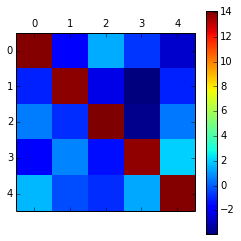

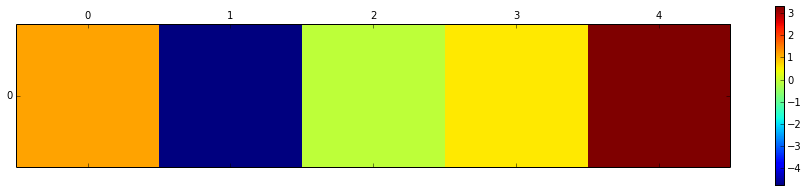

In [7]:
def show_module(m):
    plt.matshow(m.matrices[0])
    plt.colorbar()
    plt.matshow(m.b)
    plt.colorbar()

def print_module(m):
    print(m.matrices[0].w)
    print(m.b.w)
    
show_module(model.addressing.content_key)

In [8]:
print_module(model.addressing.content_key_strength)

[[ 0.75422418]
 [ 4.75511456]
 [ 0.12967382]
 [-0.07050911]
 [-1.0323782 ]]
[[ 14.32119751]]


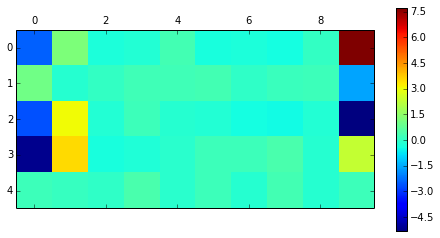

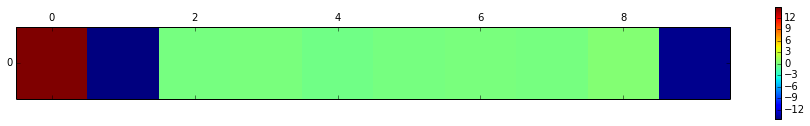

In [9]:
show_module(model.addressing.shift)

In [10]:
print_module(model.addressing.interpolation)

[[ 1.55468297]
 [ 3.15778613]
 [-0.18866539]
 [-0.74233472]
 [-2.23694587]]
[[ 14.10259438]]


In [11]:
print_module(model.addressing.focus)

[[-1.92003334]
 [-1.05372655]
 [ 1.08403599]
 [-1.66416633]
 [ 3.70808768]]
[[ 14.14016438]]
